# Определение стоимости автомобилей

<b>Цели проекта:</b>  
Построить модель для определения стоимости автомобилей.  
  
<b>Задачи проекта:</b>  
1. провести предобработку данных;
2. разбить данные на выборки;  
3. исследовать модели (будем решать задачу с учителем: в распоряжении обучающий набор данных и целевой признак, который нужно предсказать по остальным признакам),
    - RandomForestRegressor,
    - LogisticRegression;
    - CatBoost;
    - LightGBM;
4. выбрать лучшую модель;  
5. сделать общие выводы.

<b>Данные:</b>  
Данные о технических характеристиках, комплектации и ценах других автомобилей.

<b>Описание данных</b>  
<i>Признаки</i>
- <code> DateCrawled </code> — дата скачивания анкеты из базы
- <code> VehicleType </code> — тип автомобильного кузова
- <code> RegistrationYear </code> — год регистрации автомобиля
- <code> Gearbox </code> — тип коробки передач
- <code> Power </code> — мощность (л. с.)
- <code> Model </code> — модель автомобиля
- <code> Kilometer </code> — пробег (км)
- <code> RegistrationMonth </code> — месяц регистрации автомобиля
- <code> FuelType </code> — тип топлива
- <code> Brand </code> — марка автомобиля
- <code> Repaired </code> — была машина в ремонте или нет
- <code> DateCreated </code> — дата создания анкеты
- <code> NumberOfPictures </code> — количество фотографий автомобиля
- <code> PostalCode </code> — почтовый индекс владельца анкеты (пользователя)
- <code> LastSeen </code> — дата последней активности пользователя  
  
<i>Целевой признак</i>
- <code> Price </code> — цена (евро)

## Подготовка данных

In [1]:
# импортировать библиотеки
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import time
import numpy as np

# вспомогательные методы
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# для простых моделей
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# для бустинга
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgbm

In [2]:
# записать файл в data
try: 
    data = pd.read_csv('/datasets/autos.csv', sep=',')
except:
    data = pd.read_csv('autos.csv', sep=',')

In [3]:
# открыть файл
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
# найти максимальное значение в 'DateCrawled' для дальнейшей работы
data['DateCrawled'].max()

'2016-04-07 14:36:58'

Не все параметры нужны для определение стоимости автомобиля. Удалим эти параметры.

In [5]:
del data['DateCrawled'], data['DateCreated'], data['NumberOfPictures'], data['PostalCode'], data['LastSeen']

In [6]:
# изучить файл: метод info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  Repaired           283215 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


Обнаружены пропуски в столбцах <code>VehicleType</code>, <code>Gearbox</code>, <code>Model</code>, <code>FuelType</code>, <code>Repaired</code>. Восстановить эти данные мы не сможем. Проверим, сколько процентов от всего датасета занимают пропуски.

In [7]:
data_1 = data
data_1 = data_1.dropna()
data_1.info()
print()
print((data.shape[0] - data_1.shape[0]) / data.shape[0])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245814 entries, 3 to 354367
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              245814 non-null  int64 
 1   VehicleType        245814 non-null  object
 2   RegistrationYear   245814 non-null  int64 
 3   Gearbox            245814 non-null  object
 4   Power              245814 non-null  int64 
 5   Model              245814 non-null  object
 6   Kilometer          245814 non-null  int64 
 7   RegistrationMonth  245814 non-null  int64 
 8   FuelType           245814 non-null  object
 9   Brand              245814 non-null  object
 10  Repaired           245814 non-null  object
dtypes: int64(5), object(6)
memory usage: 22.5+ MB

0.30633322892239445


Если удалить строки с пропущенными значениями, то мы потеряем 30% данных, а это много. Следовательно, дальше будем использовать заглушку.

In [8]:
# изучение данных: метод describe()
display(data.describe())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645
std,4514.158514,90.227958,189.850405,37905.341530,3.726421
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


Можем заметить, что есть выбросы в обе стороны у <code>RegistrationYear</code> и <code>Power</code>, также есть нулевые значения в <code>RegistrationMonth</code> и <code>Price</code>.

#### RegistrationYear

Начнём обработку с года регистрации.

Так как последняя запись в 'DateCrawled' была сделана в 2016 году, то уберём все записи автомобилей, которые были зарегистрированы позже 2016 года.

In [9]:
# посчитать количество записей, где год регистрации автомобиля меньше 1980 и больше 2016
data[(data['RegistrationYear'] < 1980) | (data['RegistrationYear'] > 2016)]['Price'].count()

17982

Количество записей равно 1% от всего датасета, поэтому мы можем удалить выбросы.

In [10]:
# удалить записи, где год регистрации автомобиля меньше 1980 и больше 2016
data = data.query('RegistrationYear >= 1980 & RegistrationYear < 2016')

In [11]:
# проверить
data[(data['RegistrationYear'] < 1980) | (data['RegistrationYear'] > 2016)]['Price'].count()

0

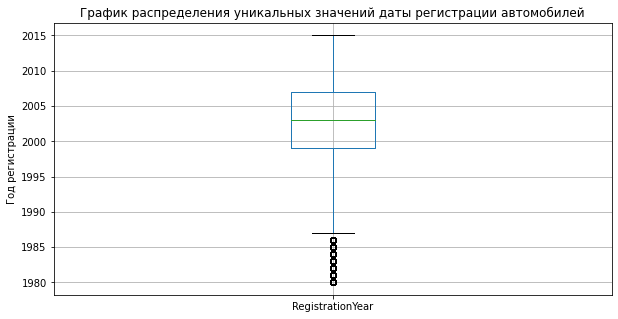

In [12]:
data.boxplot('RegistrationYear', figsize=(10,5))
plt.title('График распределения уникальных значений даты регистрации автомобилей')
plt.ylabel('Год регистрации')
plt.xlabel('')
plt.show()

#### Power

Обработаем данные с мощностью.

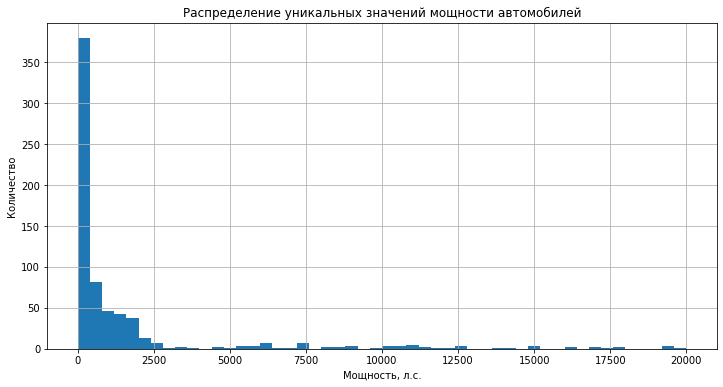

In [13]:
pd.Series(list(data.Power.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(12,6), grid=True, bins=50)
plt.title('Распределение уникальных значений мощности автомобилей')
plt.ylabel('Количество')
plt.xlabel('Мощность, л.с.')
plt.show()

Средняя мощность автомобилей в 2020 году была около 210 л.с. Экономичные автомобили, как правило, имеют мощность 170-190 л.с. В 1980 году средняя мощность автомобилей была около 80 л.с. Самая большая мощность у автомобилей на данный момент около 2000 л.с. Поэтому посчитаем, количество записей, где мощность меньше 80 и больше 2000. 

In [14]:
# посчитать количество записей, где мощность автомобиля меньше 80 и больше 2000
data[(data['Power'] < 80) | (data['Power'] > 2000)]['Price'].count()

106725

Количество записей получилось около 30% от исходного датасета.

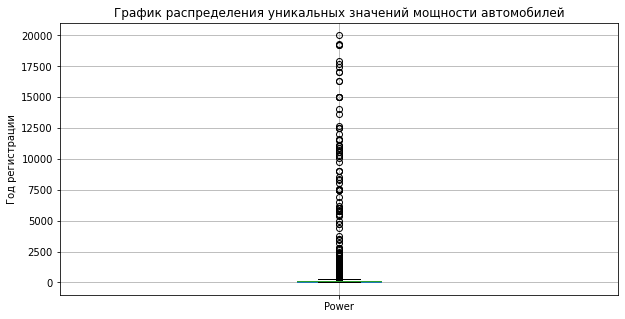

In [15]:
data.boxplot('Power', figsize=(10,5))
plt.title('График распределения уникальных значений мощности автомобилей')
plt.ylabel('Год регистрации')
plt.xlabel('')
plt.show()

In [16]:
data.Power.describe()

count    326788.000000
mean        112.284402
std         180.916863
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [17]:
data.loc[data['Power'] > 5000].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
7661,1499,small,1999,manual,7515,lupo,150000,4,petrol,volkswagen,NaN
11039,0,sedan,1998,manual,10317,other,150000,8,petrol,fiat,no
25232,10900,bus,2009,manual,10520,caddy,150000,6,gasoline,volkswagen,no
33952,3740,small,2006,manual,6920,aygo,90000,10,NaN,toyota,no
44520,2500,convertible,1998,manual,7512,golf,150000,6,NaN,volkswagen,NaN


После изучения объявлений о моделях машин первых десяти записей с условием, что количество лошадиных сил больше 15000, можно сделать вывод, что можно поделить эти значения на 100. 

In [18]:
# посчитать количество записей, где мощность автомобиля больше 3000
data[(data['Power'] > 5000)]['Price'].count()

68

In [19]:
# заменить значения
data.loc[data['Power'] > 5000, 'Power'] = data['Power']/100

In [20]:
# проверить
data[(data['Power'] > 5000)]['Price'].count()

0

In [21]:
data.loc[(data['Power'] < 20) & (data['Power'] > 6)].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
3349,1990,small,2004,NaN,7.0,polo,150000,5,gasoline,volkswagen,no
4637,870,wagon,2000,manual,16.0,focus,150000,0,NaN,ford,no
12571,5999,small,2014,auto,15.0,other,10000,3,electric,renault,no
13227,5799,small,2013,auto,18.0,other,10000,6,electric,renault,no
22708,200,coupe,2001,manual,14.0,other,5000,3,petrol,toyota,yes


После изучения объявлений о моделях машин первых десяти записей с условием, что количество лошадиных сил меньше 20 и больше 6, можно сделать вывод, что значения можно умножить на 10.

In [22]:
# заменить значения
data.loc[(data['Power'] < 20) & (data['Power'] > 4), 'Power'] = data['Power']*10

In [23]:
# проверить
data[(data['Power'] < 20) & (data['Power'] > 4)]['Price'].count()

0

In [24]:
# посчитать количество записей, где мощность автомобиля больше 2500 и меньше 20
data[(data['Power'] < 20) & (data['Power'] < 2500)]['Price'].count()

32633

In [25]:
# удалить записи, где мощность автомобиля меньше 30 и больше 2500
data = data.query('Power >= 30 & Power < 2500')

In [26]:
# проверить
data[(data['Power'] < 30) | (data['Power'] > 2500)]['Price'].count()

0

#### RegistrationMonth

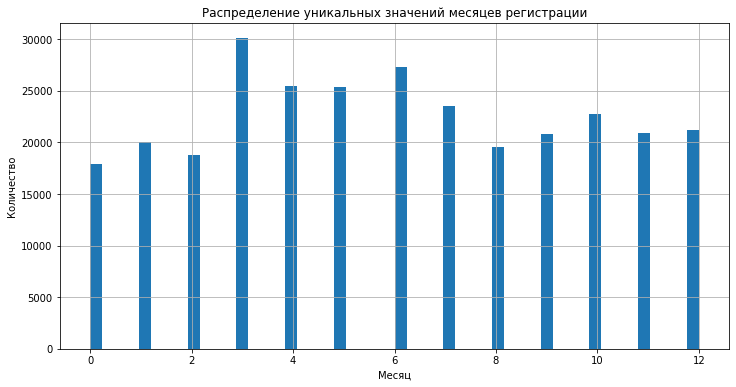

In [27]:
pd.Series(list(data.RegistrationMonth)).sort_values(ascending=False).plot(kind='hist', 
                                                                          figsize=(12,6), grid=True, bins=50)
plt.title('Распределение уникальных значений месяцев регистрации')
plt.ylabel('Количество')
plt.xlabel('Месяц')
plt.show()

Заменим строки со значением 0 на медианное (среднее почти равно 6).

In [28]:
# найти медиану
print(data['RegistrationMonth'].median())

# заменить нулевые значения на медианное
data['RegistrationMonth'] = data['RegistrationMonth'].replace(0, 6)

# проверяем, что строк с нулевым значением нет
data[(data['RegistrationMonth'] == 0)]['Price'].count()

6.0


0

#### Price

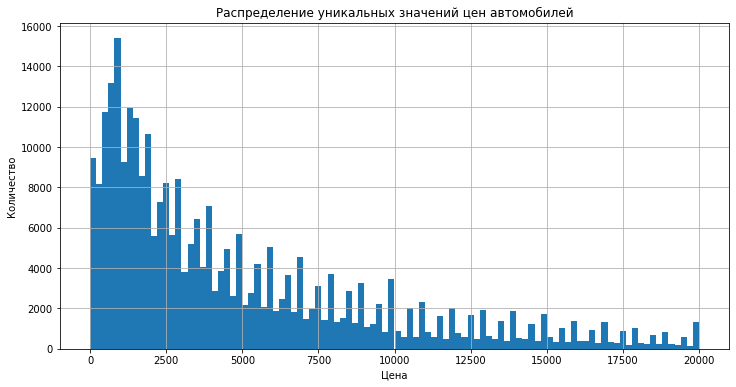

In [29]:
pd.Series(list(data.Price)).sort_values(ascending=False).plot(kind='hist', figsize=(12,6), grid=True, bins=100)
plt.title('Распределение уникальных значений цен автомобилей')
plt.ylabel('Количество')
plt.xlabel('Цена')
plt.show()

Видим, что у нас есть много около нулевых значений.

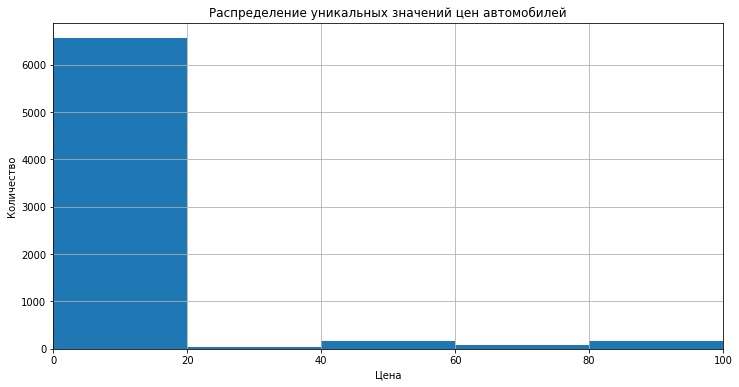

In [30]:
pd.Series(list(data.Price)).sort_values(ascending=False).plot(kind='hist', figsize=(12,6), grid=True, bins=1000)
plt.title('Распределение уникальных значений цен автомобилей')
plt.ylabel('Количество')
plt.xlabel('Цена')
plt.xlim(0,100)
plt.show()

In [31]:
# удалить строчки, где цена меньше 10
data = data.query('Price > 10')

In [32]:
# проверка
data[(data['Price'] < 10)]['Price'].count()

0

#### Оставшиеся столбцы

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287254 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              287254 non-null  int64  
 1   VehicleType        282582 non-null  object 
 2   RegistrationYear   287254 non-null  int64  
 3   Gearbox            282523 non-null  object 
 4   Power              287254 non-null  float64
 5   Model              277419 non-null  object 
 6   Kilometer          287254 non-null  int64  
 7   RegistrationMonth  287254 non-null  int64  
 8   FuelType           274546 non-null  object 
 9   Brand              287254 non-null  object 
 10  Repaired           247608 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 26.3+ MB


In [34]:
data.VehicleType.unique()

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'other', nan], dtype=object)

Заменим nan на Unknown.

In [35]:
# заменить пропуски на Unknown
data['VehicleType'] = data['VehicleType'].fillna('Unknown')

Информация о типе коробки передач довольно важная, поэтому удалим строчки с nan.

In [36]:
# удалить пропуски в Gearbox
data.dropna(subset=['Gearbox'], inplace=True)

In [37]:
data.Gearbox.unique()

array(['manual', 'auto'], dtype=object)

Информация о моделе автомобиля самая важная, поэтому удалим строчки с nan.

In [38]:
# удалить пропуски в Model
data.dropna(subset=['Model'], inplace=True)

In [39]:
# заменить пропуски на other
data['FuelType'] = data['FuelType'].fillna('other')

In [40]:
data.FuelType.unique()

array(['gasoline', 'petrol', 'other', 'lpg', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [41]:
data.Repaired.unique()

array([nan, 'no', 'yes'], dtype=object)

In [42]:
# заменить пропуски на Unknown
data['Repaired'] = data['VehicleType'].fillna('Unknown')

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273249 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              273249 non-null  int64  
 1   VehicleType        273249 non-null  object 
 2   RegistrationYear   273249 non-null  int64  
 3   Gearbox            273249 non-null  object 
 4   Power              273249 non-null  float64
 5   Model              273249 non-null  object 
 6   Kilometer          273249 non-null  int64  
 7   RegistrationMonth  273249 non-null  int64  
 8   FuelType           273249 non-null  object 
 9   Brand              273249 non-null  object 
 10  Repaired           273249 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 25.0+ MB


In [44]:
data.shape

(273249, 11)

### Корреляция

In [45]:
# посмотреть корреляцию
data.corr().style.background_gradient(cmap='coolwarm')

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
Price,1.000000,0.641710,0.428102,-0.397537,0.016033
RegistrationYear,0.641710,1.000000,0.132429,-0.421000,-0.002699
Power,0.428102,0.132429,1.000000,0.084448,0.018092
Kilometer,-0.397537,-0.421000,0.084448,1.000000,0.001147
RegistrationMonth,0.016033,-0.002699,0.018092,0.001147,1.000000


Видим, что есть зависимость между ценой и годом регистрации, ценой и мощностью двигателя (чем больше значение года регистрации или мощности автомобиля, тем выше цена), ценой и пробегом (чем выше цена, тем меньше пробег), пробегом и годом регистрации (чем выше значение года регистрации, тем меньше пробег).

### OrdinalEncoder

При работе с любыми данными, связанными с ранжированием чего-либо с помощью нечисловых категорий, лучше всего использовать OrdinalEncoder.

Необходимо выбрать значимые столбцы, имеющие значение в ценообразовании.

In [46]:
# категориальные признаки
category_features = ['VehicleType', 'Gearbox', 'Brand', 'Model', 'FuelType', 'Repaired', 'RegistrationMonth']

# числовые признаки
number_features = ['RegistrationYear', 'Power', 'Kilometer']

In [47]:
# создать новый датасет
df = data[number_features + category_features + ['Price']].copy()
#сбросить индексы
df = df.reset_index(drop=True)
# напечатать
df.head()

,RegistrationYear,Power,Kilometer,VehicleType,Gearbox,Brand,Model,FuelType,Repaired,RegistrationMonth,Price
0,2004,163.0,125000,suv,auto,jeep,grand,gasoline,suv,8,9800
1,2001,75.0,150000,small,manual,volkswagen,golf,petrol,small,6,1500
2,2008,69.0,90000,small,manual,skoda,fabia,gasoline,small,7,3600
3,1995,102.0,150000,sedan,manual,bmw,3er,petrol,sedan,10,650
4,2004,109.0,150000,convertible,manual,peugeot,2_reihe,petrol,convertible,8,2200


### Выборки

Разделим новый датасет на выборки в отношении 3:1.

In [48]:
# разделить данные на признаки
features = df.drop(['Price'],axis=1)
target = df['Price']

In [49]:
# разделить данные на тестовую и обучающую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [50]:
# порядковое кодирование
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = category_features
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])

### StandardScaler

StandardScaler вступает в игру, когда характеристики входного набора данных сильно различаются между диапазонами или, когда они измеряются в разных единицах измерения.

In [51]:
scaler = StandardScaler()
scaler.fit(features_train_ord[number_features])


features_train_ord[number_features] = scaler.transform(features_train[number_features])
features_test_ord[number_features] = scaler.transform(features_test[number_features])


print(features_train_ord.shape)
print(features_test_ord.shape)

features_train.head()

(204936, 10)
(68313, 10)


,RegistrationYear,Power,Kilometer,VehicleType,Gearbox,Brand,Model,FuelType,Repaired,RegistrationMonth
79683,2011,126.0,30000,bus,manual,kia,other,petrol,bus,10
263469,1994,90.0,150000,sedan,manual,audi,80,petrol,sedan,11
63910,2009,143.0,125000,sedan,manual,bmw,3er,gasoline,sedan,7
59878,2001,140.0,150000,convertible,auto,toyota,other,petrol,convertible,6
183553,2001,136.0,125000,sedan,manual,kia,other,petrol,sedan,8


### Вывод

- проведена предобработка данных: удалены/изменены аномальные значения, 
- данные разделены на тестовую и обучающую выборки,
- текстовые признаки переведны в цифровой формат с помощью StandartScaler.

## Обучение моделей

In [52]:
def rmse(target, predicted):
    return (mean_squared_error(target, predicted) ** 0.5)

### RandomForestRegressor

In [53]:
%%time
start = time.time()


parameters = {'n_estimators': range(5,11,5),'max_depth': range(1,8,3), 
              'min_samples_leaf': range(1,5,2), 'min_samples_split': range(2,6,2)}

model_rfr = RandomForestRegressor()
grid = GridSearchCV(model_rfr, parameters, cv=3, scoring='neg_mean_squared_error', error_score='raise')
grid.fit(features_train_ord, target_train)

grid.best_params_

CPU times: user 1min 1s, sys: 118 ms, total: 1min 1s
Wall time: 1min 2s


{'max_depth': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 10}

In [54]:
%%time
start = time.time()


model_rfr = RandomForestRegressor(max_depth=7, min_samples_leaf=3, 
                              min_samples_split=2, n_estimators=10, random_state=12345)
model_rfr.fit(features_train_ord, target_train)


end = time.time()
t_rfr_1 = round(end-start,2)

CPU times: user 2.93 s, sys: 8 ms, total: 2.94 s
Wall time: 2.98 s


In [55]:
%%time
start = time.time()


pred_rfr = model_rfr.predict(features_train_ord)

end = time.time()
t_rfr_2 = round(end-start,2)

result_rfr = rmse(target_train, pred_rfr)
print('RMSE RandomForestRegressor = ', result_rfr)
print()

RMSE RandomForestRegressor =  2039.808172520536

CPU times: user 141 ms, sys: 0 ns, total: 141 ms
Wall time: 141 ms


### CatBoostRegressor

In [56]:
# подготовить заново признаки для бустинга
features = data.drop(columns='Price')
target = data['Price']

# разделить выборку на обучающую и тестовую
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

# провести скалирование
scaler = StandardScaler()
scaler.fit(features_train[number_features])
features_train[number_features] = scaler.transform(features_train[number_features])
features_test[number_features] = scaler.transform(features_test[number_features])

/tmp/ipykernel_157/4221834740.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[number_features] = scaler.transform(features_train[number_features])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_157/4221834740.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [57]:
%%time
start = time.time()


model_cat = CatBoostRegressor(loss_function="RMSE", iterations=50)
model_cat.fit(features_train, target_train, cat_features=category_features, verbose=10)


end = time.time()
t_cat_1 = round(end-start,2)

Learning rate set to 0.5
0:	learn: 3169.7893825	total: 166ms	remaining: 8.14s
10:	learn: 1847.7156693	total: 1.16s	remaining: 4.12s
20:	learn: 1761.1702988	total: 2.1s	remaining: 2.9s
30:	learn: 1719.6410213	total: 3.09s	remaining: 1.9s
40:	learn: 1689.1950421	total: 4.23s	remaining: 928ms
49:	learn: 1670.5622316	total: 5.2s	remaining: 0us
CPU times: user 5.52 s, sys: 95.2 ms, total: 5.62 s
Wall time: 6.66 s


In [58]:
%%time
start = time.time()


pred_cat = model_cat.predict(features_train)

end = time.time()
t_cat_2 = round(end-start,2)

result_cat = rmse(target_train, pred_cat)
print('RMSE CatBoost = ', result_cat)
print()

RMSE CatBoost =  1667.3604497354756

CPU times: user 379 ms, sys: 3.94 ms, total: 383 ms
Wall time: 417 ms


### LightGBM

In [59]:
features_train_gbm = features_train.copy()
features_test_gbm = features_test.copy()

category_features_gbm = ['VehicleType', 'Gearbox', 'Brand', 'Model', 'FuelType', 'Repaired']

encoder = OrdinalEncoder()
encoder.fit(features_train_gbm[category_features_gbm])
features_train_gbm[category_features_gbm] = encoder.transform(features_train_gbm[category_features_gbm])
features_test_gbm[category_features_gbm] = encoder.transform(features_test_gbm[category_features_gbm])

features_train_gbm.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
103199,1.0,1.448801,1.0,0.057416,166.0,-2.714972,10,6.0,15.0,1.0
341694,5.0,-1.589854,1.0,-0.520426,20.0,0.592037,11,6.0,1.0,5.0
82930,5.0,1.091312,1.0,0.330285,11.0,-0.096924,7,2.0,2.0,5.0
77701,2.0,-0.338643,0.0,0.282132,166.0,0.592037,6,6.0,35.0,2.0
238206,5.0,-0.338643,1.0,0.217927,166.0,-0.096924,8,6.0,15.0,5.0


In [60]:
%%time
start = time.time()


model_lgbm = LGBMRegressor(boosting_type='gbdt', verbose=0, seed=12345)
model_lgbm.fit(features_train_gbm, target_train, eval_set=(features_test_gbm, target_test))


end = time.time()
t_lgbm_1 = round(end-start,2)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's l2: 1.86193e+07
[2]	valid_0's l2: 1.60916e+07
[3]	valid_0's l2: 1.40195e+07
[4]	valid_0's l2: 1.2319e+07
[5]	valid_0's l2: 1.09175e+07
[6]	valid_0's l2: 9.76333e+06
[7]	valid_0's l2: 8.7971e+06
[8]	valid_0's l2: 7.99876e+06
[9]	valid_0's l2: 7.35124e+06
[10]	valid_0's l2: 6.79393e+06
[11]	valid_0's l2: 6.34224e+06
[12]	valid_0's l2: 5.95588e+06
[13]	valid_0's l2: 5.62127e+06
[14]	valid_0's l2: 5.34338e+06
[15]	valid_0's l2: 5.09574e+06
[16]	valid_0's l2: 4.88111e+06
[17]	valid_0's l2: 4.69177e+06
[18]	valid_0's l2: 4.531e+06
[19]	valid_0's l2: 4.401e+06
[20]	valid_0's l2: 4.26954e+06
[21]	valid_0's l2: 4.16276e+06
[22]	valid_0's l2: 4.07227e+06
[23]	valid_0's l2: 3.9869e+06
[24]	valid_0's l2: 3.91035e+06
[25]	valid_0's l2: 3.82236e+06
[26]	valid_0

In [61]:
%%time
start = time.time()


pred_lgbm = model_lgbm.predict(features_train_gbm)


end = time.time()
t_lgbm_2 = round(end-start,2)

result_lgbm = rmse(target_train, pred_lgbm)
print('RMSE LinearRegression = ', result_lgbm)
print()

RMSE LinearRegression =  1632.2125307358694

CPU times: user 1.52 s, sys: 9.1 ms, total: 1.53 s
Wall time: 1.52 s


## Анализ моделей

In [62]:
data_end = [{'Модель': 'RandomForestRegressor', 'Время обучения': t_rfr_1, 
             'Время предсказания': t_rfr_2, 'RMSE': result_rfr}, 
            {'Модель': 'CatBoost', 'Время обучения': t_cat_1, 
             'Время предсказания': t_cat_2, 'RMSE': result_cat},
            {'Модель': 'LightGBM', 'Время обучения': t_lgbm_1, 
             'Время предсказания': t_lgbm_2, 'RMSE': result_lgbm}]

dframe = pd.DataFrame(data_end, columns =['Модель', 'Время обучения', 'Время предсказания', 'RMSE'])
dframe

,Модель,Время обучения,Время предсказания,RMSE
0,RandomForestRegressor,2.98,0.14,2039.808173
1,CatBoost,6.66,0.42,1667.360450
2,LightGBM,433.24,1.52,1632.212531


Качество предсказания у CatBoot и LightGBM практически одинаковое (LightGBM) немного выигрывает. Время обчуения у LightGBM довольно больше остальных моделей. Время предсказания у LightGBM тоже больше. Лучше всего справилась модель CatBoost.

## Тестирование лучшей модели

Лучше всего на обучающей выборке показала себя модель CatBoost. Проведём тестирование этой модели.

In [63]:
%%time
start = time.time()
pred_cat_new = model_cat.predict(features_test)

end = time.time()
t_cat_2 = round(end-start,2)

result_cat_new = rmse(target_test, pred_cat_new)
print('RMSE CatBoost = ', result_cat_new)
print()

RMSE CatBoost =  1701.6945070542681

CPU times: user 115 ms, sys: 0 ns, total: 115 ms
Wall time: 124 ms


## Выводы

1. <b>Проведена предобработка данных</b>  
    - Проведена работа с аномальными значениями.  
    - Проведена работа с пропусками.  
    - Изучена корреляция между признаками.  
2. <b>Данные разбиты на выборки</b> 
    - Данные были разбиты на две выборки: обучающая и тестовая в отношении 3:1 соответственно.
    - Использован OrdinalEncoder.
    - Использован StandardScaler.
3. <b>Исследованы модели</b> 
    - RandomForestRegressor: RMSE = 2124.144450.
    - LinearRegression: RMSE = 3181.420617.
    - CatBoost: RMSE = 1737.870490.
    - LightGBM: RMSE = 1713.555717.
4. <b>Лучшей моделью по критериям (время обучения, время предсказания, RMSE) выбрана CatBoost.</b>